# Part 5: Boosted Decision Trees

The `conifer` package was created out of `hls4ml`, providing a similar set of features but specifically targeting inference of Boosted Decision Trees. In this notebook we will train a `GradientBoostingClassifier` with scikit-learn, using the same jet tagging dataset as in the other tutorial notebooks. Then we will convert the model using `conifer`, and run bit-accurate prediction and synthesis as we did with `hls4ml` before.

`conifer` is available from GitHub [here](https://github.com/thesps/conifer), and we have a publication describing the inference implementation and performance in detail [here](https://iopscience.iop.org/article/10.1088/1748-0221/15/05/P05026/pdf).

<img src="https://github.com/thesps/conifer/blob/master/conifer_v1.png?raw=true" width="250" alt="conifer">

In [2]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
import joblib
import conifer
import plotting
import matplotlib.pyplot as plt
import os

os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']
np.random.seed(0)

Could not import conifer xgboost converter
Could not import conifer ydf converter
runtime module could not be imported. Interacting with accelerators will not be possible.
runtime module could not be imported. Interacting with FPUs will not be possible.


## Load the dataset
Note you need to have gone through `part1_getting_started` to download the data.

In [3]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

We need to transform the test labels from the one-hot encoded values to labels

In [4]:
le = LabelEncoder().fit(classes)
ohe = OneHotEncoder().fit(le.transform(classes).reshape(-1, 1))
y_train_val = ohe.inverse_transform(y_train_val.astype(int))
y_test = ohe.inverse_transform(y_test)

## Train a `GradientBoostingClassifier`
We will use 20 estimators with a maximum depth of 3. The number of decision trees will be `n_estimators * n_classes`, so 100 for this dataset. If you are returning to this notebook having already trained the BDT once, set `train = False` to load the model rather than retrain.

In [5]:
train = True
if train:
    clf = GradientBoostingClassifier(n_estimators=20, learning_rate=1.0, max_depth=3, random_state=0, verbose=1).fit(
        X_train_val, y_train_val.ravel()
    )
    if not os.path.exists('model_5'):
        os.makedirs('model_5')
    joblib.dump(clf, 'model_5/bdt.joblib')
else:
    clf = joblib.load('model_5/bdt.joblib')

      Iter       Train Loss   Remaining Time 
         1           0.8801            6.81m
         2           0.8163            6.45m
         3           0.7776            6.09m
         4           0.7616            5.78m
         5           0.7526            5.40m
         6           0.7458            5.04m
         7           0.7403            4.67m
         8           0.7359            4.33m
         9           0.7314            3.97m
        10           0.7249            3.61m
        20           0.6992            0.00s


## Create a conifer configuration

Similarly to `hls4ml`, we can use a utility method to get a template for the configuration dictionary that we can modify.

In [20]:
cfg = conifer.backends.xilinxhls.auto_config()
cfg['OutputDir'] = 'model_5/conifer_prj'
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'
plotting.print_dict(cfg)

Backend:             xilinxhls
ProjectName:         my_prj
OutputDir:           model_5/conifer_prj
XilinxPart:          xcu250-figd2104-2L-e
ClockPeriod:         5
Unroll:              True
AcceleratorConfig:   None
Precision:           ap_fixed<18,8>


## Convert the model
The syntax for model conversion with `conifer` is a little different to `hls4ml`. We construct a `conifer.model` object, providing the trained BDT, the converter corresponding to the library we used, the conifer 'backend' that we wish to target, and the configuration.

`conifer` has converters for:
- `sklearn`
- `xgboost`
- `tmva`

And backends:
- `vivadohls`
- `vitishls`
- `xilinxhls` (use whichever `vivado` or `vitis` is on the path
- `vhdl`

Here we will use the `sklearn` converter, since that's how we trained our model, and the `vivadohls` backend. For larger BDTs with many more trees or depth, it may be preferable to generate VHDL directly using the `vhdl` backend to get best performance. See [our paper](https://iopscience.iop.org/article/10.1088/1748-0221/15/05/P05026/pdf) for the performance comparison between those backends.

In [21]:
cnf = conifer.converters.convert_from_sklearn(clf, cfg)
#cnf = conifer.model(clf, conifer.converters.sklearn, conifer.backends.xilinxhls, cfg)
cnf.compile()

## profile
Similarly to hls4ml, we can visualize the distribution of the parameters of the BDT to guide the choice of precision

In [28]:
cnf.profile()

AttributeError: 'XilinxHLSModel' object has no attribute '_ensembleDict'

## Run inference
Now we can execute the BDT inference with `sklearn`, and also the bit exact simulation using Vivado HLS. The output that the `conifer` BDT produces is equivalent to the `decision_function` method.

In [23]:
y_skl = clf.decision_function(X_test)
y_cnf = cnf.decision_function(X_test)

## Check performance

Print the accuracy from `sklearn` and `conifer` evaluations, and plot the ROC curves. We should see that we can get quite close to the accuracy of the Neural Networks from parts 1-4.

Accuracy sklearn: 0.749132530120482
Accuracy conifer: 0.7489698795180723


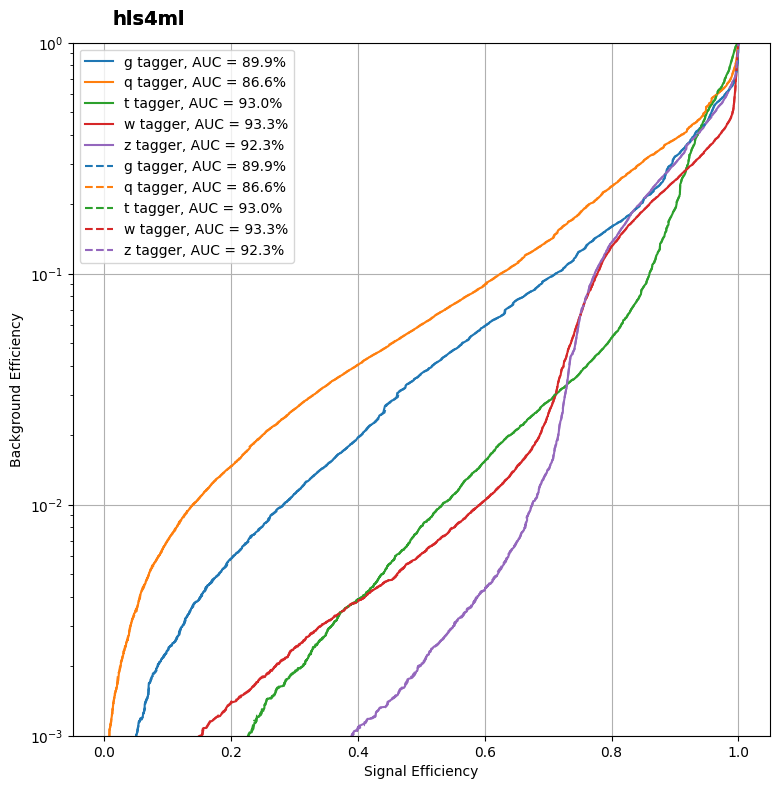

In [24]:
yt = ohe.transform(y_test).toarray().astype(int)
print("Accuracy sklearn: {}".format(accuracy_score(np.argmax(yt, axis=1), np.argmax(y_skl, axis=1))))
print("Accuracy conifer: {}".format(accuracy_score(np.argmax(yt, axis=1), np.argmax(y_cnf, axis=1))))
fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(yt, y_skl, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(yt, y_cnf, classes, linestyle='--')

## Synthesize
Now run the Vivado HLS C Synthesis step to produce an IP that we can use, and inspect the estimate resources and latency.
You can see some live output while the synthesis is running by opening a terminal from the Jupyter home page and executing:
`tail -f model_5/conifer_prj/vivado_hls.log`

In [25]:
cnf.build()

True

## Read report
We can use an hls4ml utility to read the Vivado report

In [27]:
import hls4ml

hls4ml.report.read_vivado_report('model_5/conifer_prj/')

UnboundLocalError: local variable 'backend_name' referenced before assignment